# Clusters de datos demográficos (Kmeans) etiquetados con FCA

## Carga de los datos
Cargamos los datos y retocamos algún campo

In [1]:
import pandas as pd
import numpy as np 

In [2]:
Prado_users = pd.read_csv('../data/originales/Prado_users.csv')

Prado_users.replace('<12', '0-12', inplace=True)
Prado_users.replace('>70', '70+', inplace=True)
Prado_users.replace('Argenitina', 'Argentina', inplace=True)
Prado_users.replace('USA', 'United States', inplace=True)

users = Prado_users.copy()
users.head(5)

,userId,age,gender,country
0,1,55-64,male,Spain
1,2,25-34,female,Spain
2,3,18-24,female,Spain
3,4,18-24,female,Spain
4,5,35-44,male,Spain


## Propuesta de medidas de similitud para cada campo
- Para el campo de edad colocamos una distancia de uno entre cada rango de edad consecutivo
- Para el género utilizaremos 0 y 1 respectivamente
- Para el país utilizaremos el índice descrito en *Countries_distance.csv*

In [3]:
# Edad
age_index = 1
for age_range in users['age'].unique():
    users = users.replace(age_range, age_index)
    age_index += 1

# gender
users = users.replace('female', 0)
users = users.replace('male', 1)

# country
country_punctuation = pd.read_csv('../data/Countries_distance.csv')

for country in users['country'].unique():
    if country != 'Other':
        users = users.replace(country, country_punctuation.loc[country_punctuation['Country'] == country, 'Punctuation'].to_list()[0])

users = users.replace('Other', .70)
users

,userId,age,gender,country
0,1,1,1,81.738435
1,2,2,0,81.738435
2,3,3,0,81.738435
3,4,3,0,81.738435
4,5,4,1,81.738435
...,...,...,...,...
166,298,6,1,87.811232
167,299,6,1,81.738435
168,300,2,0,81.738435
169,301,6,1,81.738435


## Escalado de los datos

In [4]:
from sklearn.preprocessing import StandardScaler

scaled_users = users.copy()
scaled_users.drop('userId', axis=1, inplace=True)
#scaled_users.set_index('userId')

scaler = StandardScaler(with_mean=False, with_std=True)

scaled_users = pd.DataFrame(data=scaler.fit_transform(scaled_users), index=users['userId'], columns=['age', 'gender', 'country'])

scaled_users

,age,gender,country
userId,,,
1,0.500137,2.021723,2.508838
2,1.000274,0.000000,2.508838
3,1.500411,0.000000,2.508838
4,1.500411,0.000000,2.508838
5,2.000547,2.021723,2.508838
...,...,...,...
298,3.000821,2.021723,2.695233
299,3.000821,2.021723,2.508838
300,1.000274,0.000000,2.508838


## Buscando el número óptimo de clusters
Aplicamos Kmeans con diferente número de clusters y evaluamos cual de ellos tiene el cociente *Davies–Bouldin* más bajo para utilizar ese número de conjuntos

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

MAX_CLUSTERS = 8
davies_boulding = np.zeros(MAX_CLUSTERS-2)

for k in range(2, MAX_CLUSTERS): 
    km = KMeans(init='random', n_clusters=k, random_state=123)
    km.fit(scaled_users)
    davies_boulding[k-2] = davies_bouldin_score(scaled_users, km.labels_)


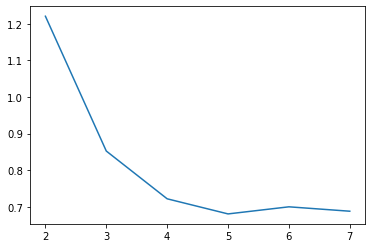

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(2, MAX_CLUSTERS), davies_boulding)

## Creamos el número óptimo de clusters

In [7]:
# Realizamos el clustering con el número óptimo de clusters
km = KMeans(init='random', n_clusters=davies_boulding.argmin()+2, random_state=333)
km.fit(scaled_users)

clusterarray = scaled_users.to_numpy()
clusterarray[:,[1, 2]] = clusterarray[:,[2, 1]]
davies_boulding.argmin()

3

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_clusters(X, labels=None, centers=None, threedim=False):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    :param threedim: si el array tiene tres dimensiones, la tercera se representa con distintos markers
    """
    
    colors = ['r','g','b','m','y','c','k']
    markers = ["+","2","^","o","*","p","d","s"]
    fig = plt.figure(figsize=(12,12))

    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases

    if threedim:
        third = np.unique(X[:,2])
        for thirdvalue in third:
            X_labels=np.append(X,labels.reshape(len(labels),-1),axis=1)
            selection = X_labels[X_labels[:,2]==thirdvalue]
            m=markers[third.tolist().index(thirdvalue) % len(markers)]
            plt.scatter(selection[:,0], selection[:,1], c=selection[:,3], marker=m ,cmap=ListedColormap(colors), s=150, linewidths = 10)
    else:
        plt.scatter(X[:,0], X[:,1], c=labels ,cmap=ListedColormap(colors))
    
    # Pintar los centroides de los clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.show()

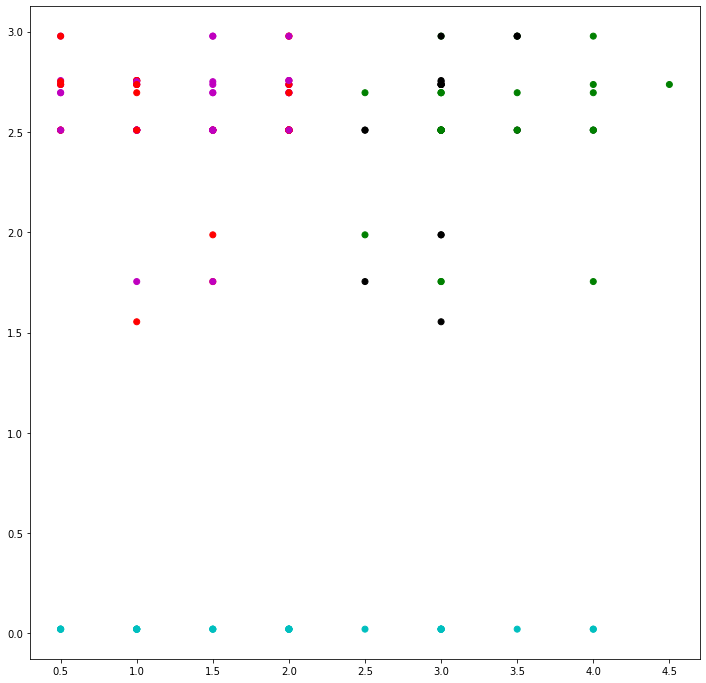

In [9]:
# Lo dibujamos

plot_clusters(clusterarray, labels=km.labels_, threedim=False)


# Etiquetado de los clusters con FCA
Primero, vamos a recabar todos los datos en un nuevo DataFrame que incluya a que cluster pertenece cada usuario

In [10]:
clustered_users = Prado_users.copy()
clustered_users['cluster'] = km.labels_
clustered_users.head(10)

,userId,age,gender,country,cluster
0,1,55-64,male,Spain,2
1,2,25-34,female,Spain,0
2,3,18-24,female,Spain,0
3,4,18-24,female,Spain,0
4,5,35-44,male,Spain,2
5,6,35-44,female,Spain,0
6,7,65-70,female,Spain,4
7,8,35-44,female,United States,0
8,9,45-54,male,Spain,1
9,10,35-44,male,Other,3


### *Convertimos las variables categóricas en otras de tipo binario*
Para poder generar un concept lattice hemos de partir de un conjunto de variables binarias. Para ello hemos de pasar de variables categóricas a variables binarias mediante funciones de pertenencia a cada posible valor de las mismas.

In [11]:
def categoricColumnsToBinary(df, columns=list()):
    for column in columns:
        for key in df[column].unique():
            df[key] = ''
            df.loc[df[column] == key, key] = 'X'

        df.drop([column], axis=1, inplace=True)


In [12]:
clustered_users_context = clustered_users.copy()

age = clustered_users_context['age'].unique()
age.sort()
age = age.reshape(3,3)
ageRanges = { 'young' : ["0-12", "13-17"],
              'youg-adult': ["18-24","25-34"],
              'adult' : ["35-44","45-54","55-64"],
              'senior' : ["65-70", "70+"]}

ranges = {}
for key in ageRanges:
    for i in ageRanges[key]:
        ranges[i] = key

for key in ranges:
    clustered_users_context.replace(key, ranges[key], inplace=True)

categoricColumnsToBinary(clustered_users_context, ['age', 'country', 'gender'])

clustered_users_context

,userId,cluster,adult,youg-adult,senior,young,Spain,United States,Other,Mexico,France,Japan,Brazil,Italy,Germany,Argentina,Canada,male,female
0,1,2,X,,,,X,,,,,,,,,,,X,
1,2,0,,X,,,X,,,,,,,,,,,,X
2,3,0,,X,,,X,,,,,,,,,,,,X
3,4,0,,X,,,X,,,,,,,,,,,,X
4,5,2,X,,,,X,,,,,,,,,,,X,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,298,1,X,,,,,,,,,,,X,,,,X,
167,299,1,X,,,,X,,,,,,,,,,,X,
168,300,0,,X,,,X,,,,,,,,,,,,X
169,301,1,X,,,,X,,,,,,,,,,,X,


### *Creamos los retículos de cada cluster a partir del contexto formal anterior*

In [13]:
from concepts import Context

clusterLattices = list()

for c in clustered_users_context['cluster'].unique():
    # Separamos las filas que pertenecen al cluster
    clusterContext = clustered_users_context[clustered_users_context['cluster'] == c]
    clusterContext.drop(['cluster'], axis=1, inplace=True)
    # Generamos el retículo correspondiente al cluster
    clusterLattices.append(Context.fromstring(clusterContext.to_csv(index=False), frmat='csv'))

In [14]:
i = 0
for lattice in clusterLattices:
    print('\nCluster %i:' % (i))
    for extent, intent in lattice.lattice:
        if len(intent) == 3:
            print(intent, len(extent))
    i+=1



Cluster 0:
('youg-adult', 'Japan', 'male') 1
('adult', 'Germany', 'male') 1
('youg-adult', 'Canada', 'male') 2
('youg-adult', 'Italy', 'male') 2
('youg-adult', 'United States', 'male') 2
('adult', 'United States', 'male') 2
('youg-adult', 'Mexico', 'male') 2
('adult', 'France', 'male') 3
('youg-adult', 'France', 'male') 3
('adult', 'Japan', 'male') 3
('adult', 'Italy', 'male') 5
('youg-adult', 'Spain', 'male') 12
('adult', 'Spain', 'male') 13

Cluster 1:
('adult', 'Germany', 'female') 1
('youg-adult', 'Italy', 'female') 1
('adult', 'Japan', 'female') 1
('youg-adult', 'Argentina', 'female') 1
('youg-adult', 'Mexico', 'female') 1
('youg-adult', 'Brazil', 'female') 1
('adult', 'Canada', 'female') 1
('adult', 'Italy', 'female') 1
('adult', 'France', 'female') 2
('youg-adult', 'France', 'female') 2
('adult', 'United States', 'female') 3
('youg-adult', 'Japan', 'female') 3
('youg-adult', 'Spain', 'female') 9
('adult', 'Spain', 'female') 14

Cluster 2:
('senior', 'Mexico', 'female') 1
('adul